In [31]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

from model import CNNModel

from PIL import Image
from crp.helper import get_layer_names
from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
from crp.attribution import CondAttribution
from crp.image import imgify
from crp.concepts import ChannelConcept


# Load model and dataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is:" + str(device))

device is:cpu


In [3]:
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
dataset = torchvision.datasets.ImageFolder(root='../generatingSpectograms/instrument_dataset', transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [5]:
model = CNNModel(len(dataset.classes))
model.load_state_dict(torch.load('./model_v1.0', weights_only=True, map_location=torch.device('cpu')))
model.eval()

CNNModel(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=12800, out_features=12, bias=True)
)

# Concept relevance propagation

## configure library settings

In [6]:
cc = ChannelConcept()

In [7]:
composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
attribution = CondAttribution(model, no_param_grad=True)

## experiments

In [8]:
# get a sample from each class

class_samples = {}
num_classes = len(dataset.classes)

for images, labels in val_loader:
    label = labels.item()
    if label not in class_samples:
        class_samples[label] = images[0] 
        if len(class_samples) == num_classes: 
            break

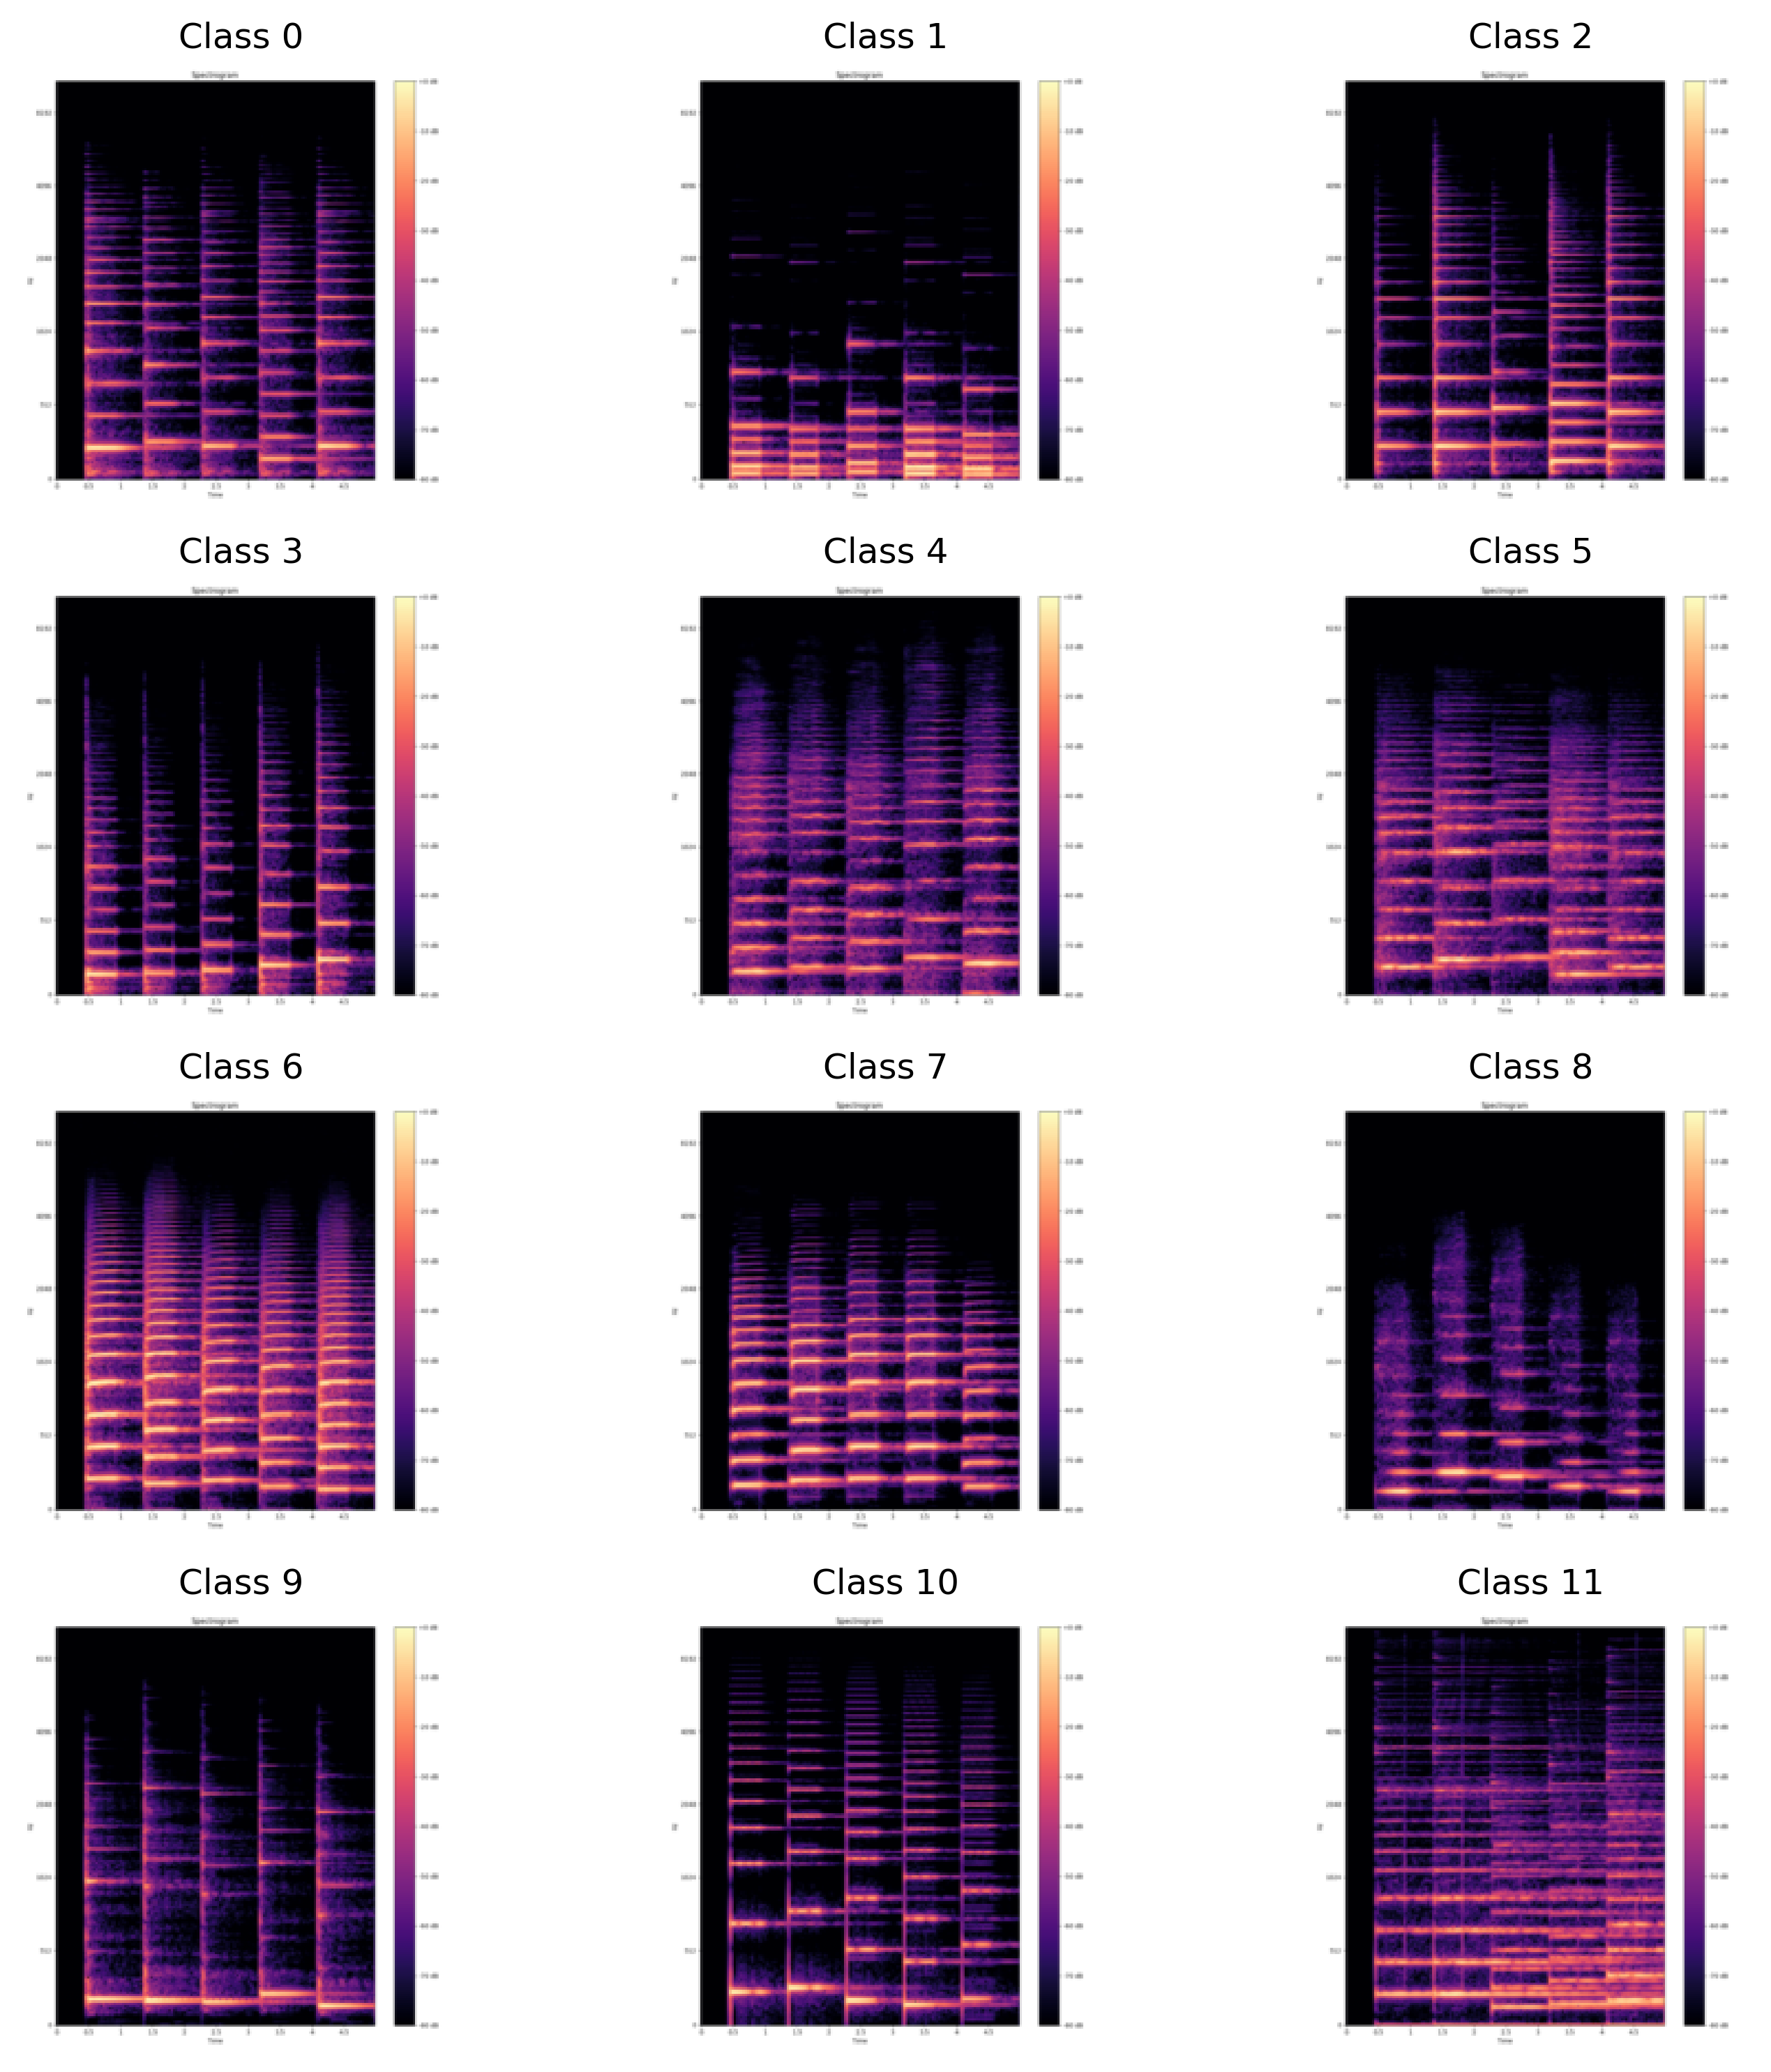

In [16]:
fig, axes = plt.subplots(4, 3, figsize=(10, 10), dpi=300)
for class_label, ax in enumerate(axes.flatten()):
    img_tensor = class_samples[class_label]
    img = img_tensor.permute(1, 2, 0).numpy()
    ax.imshow((img+1)/2, cmap='seismic')
    ax.set_title(f"Class {class_label}")
    ax.axis("off")  # Hide axes for clarity

plt.tight_layout()
plt.show()

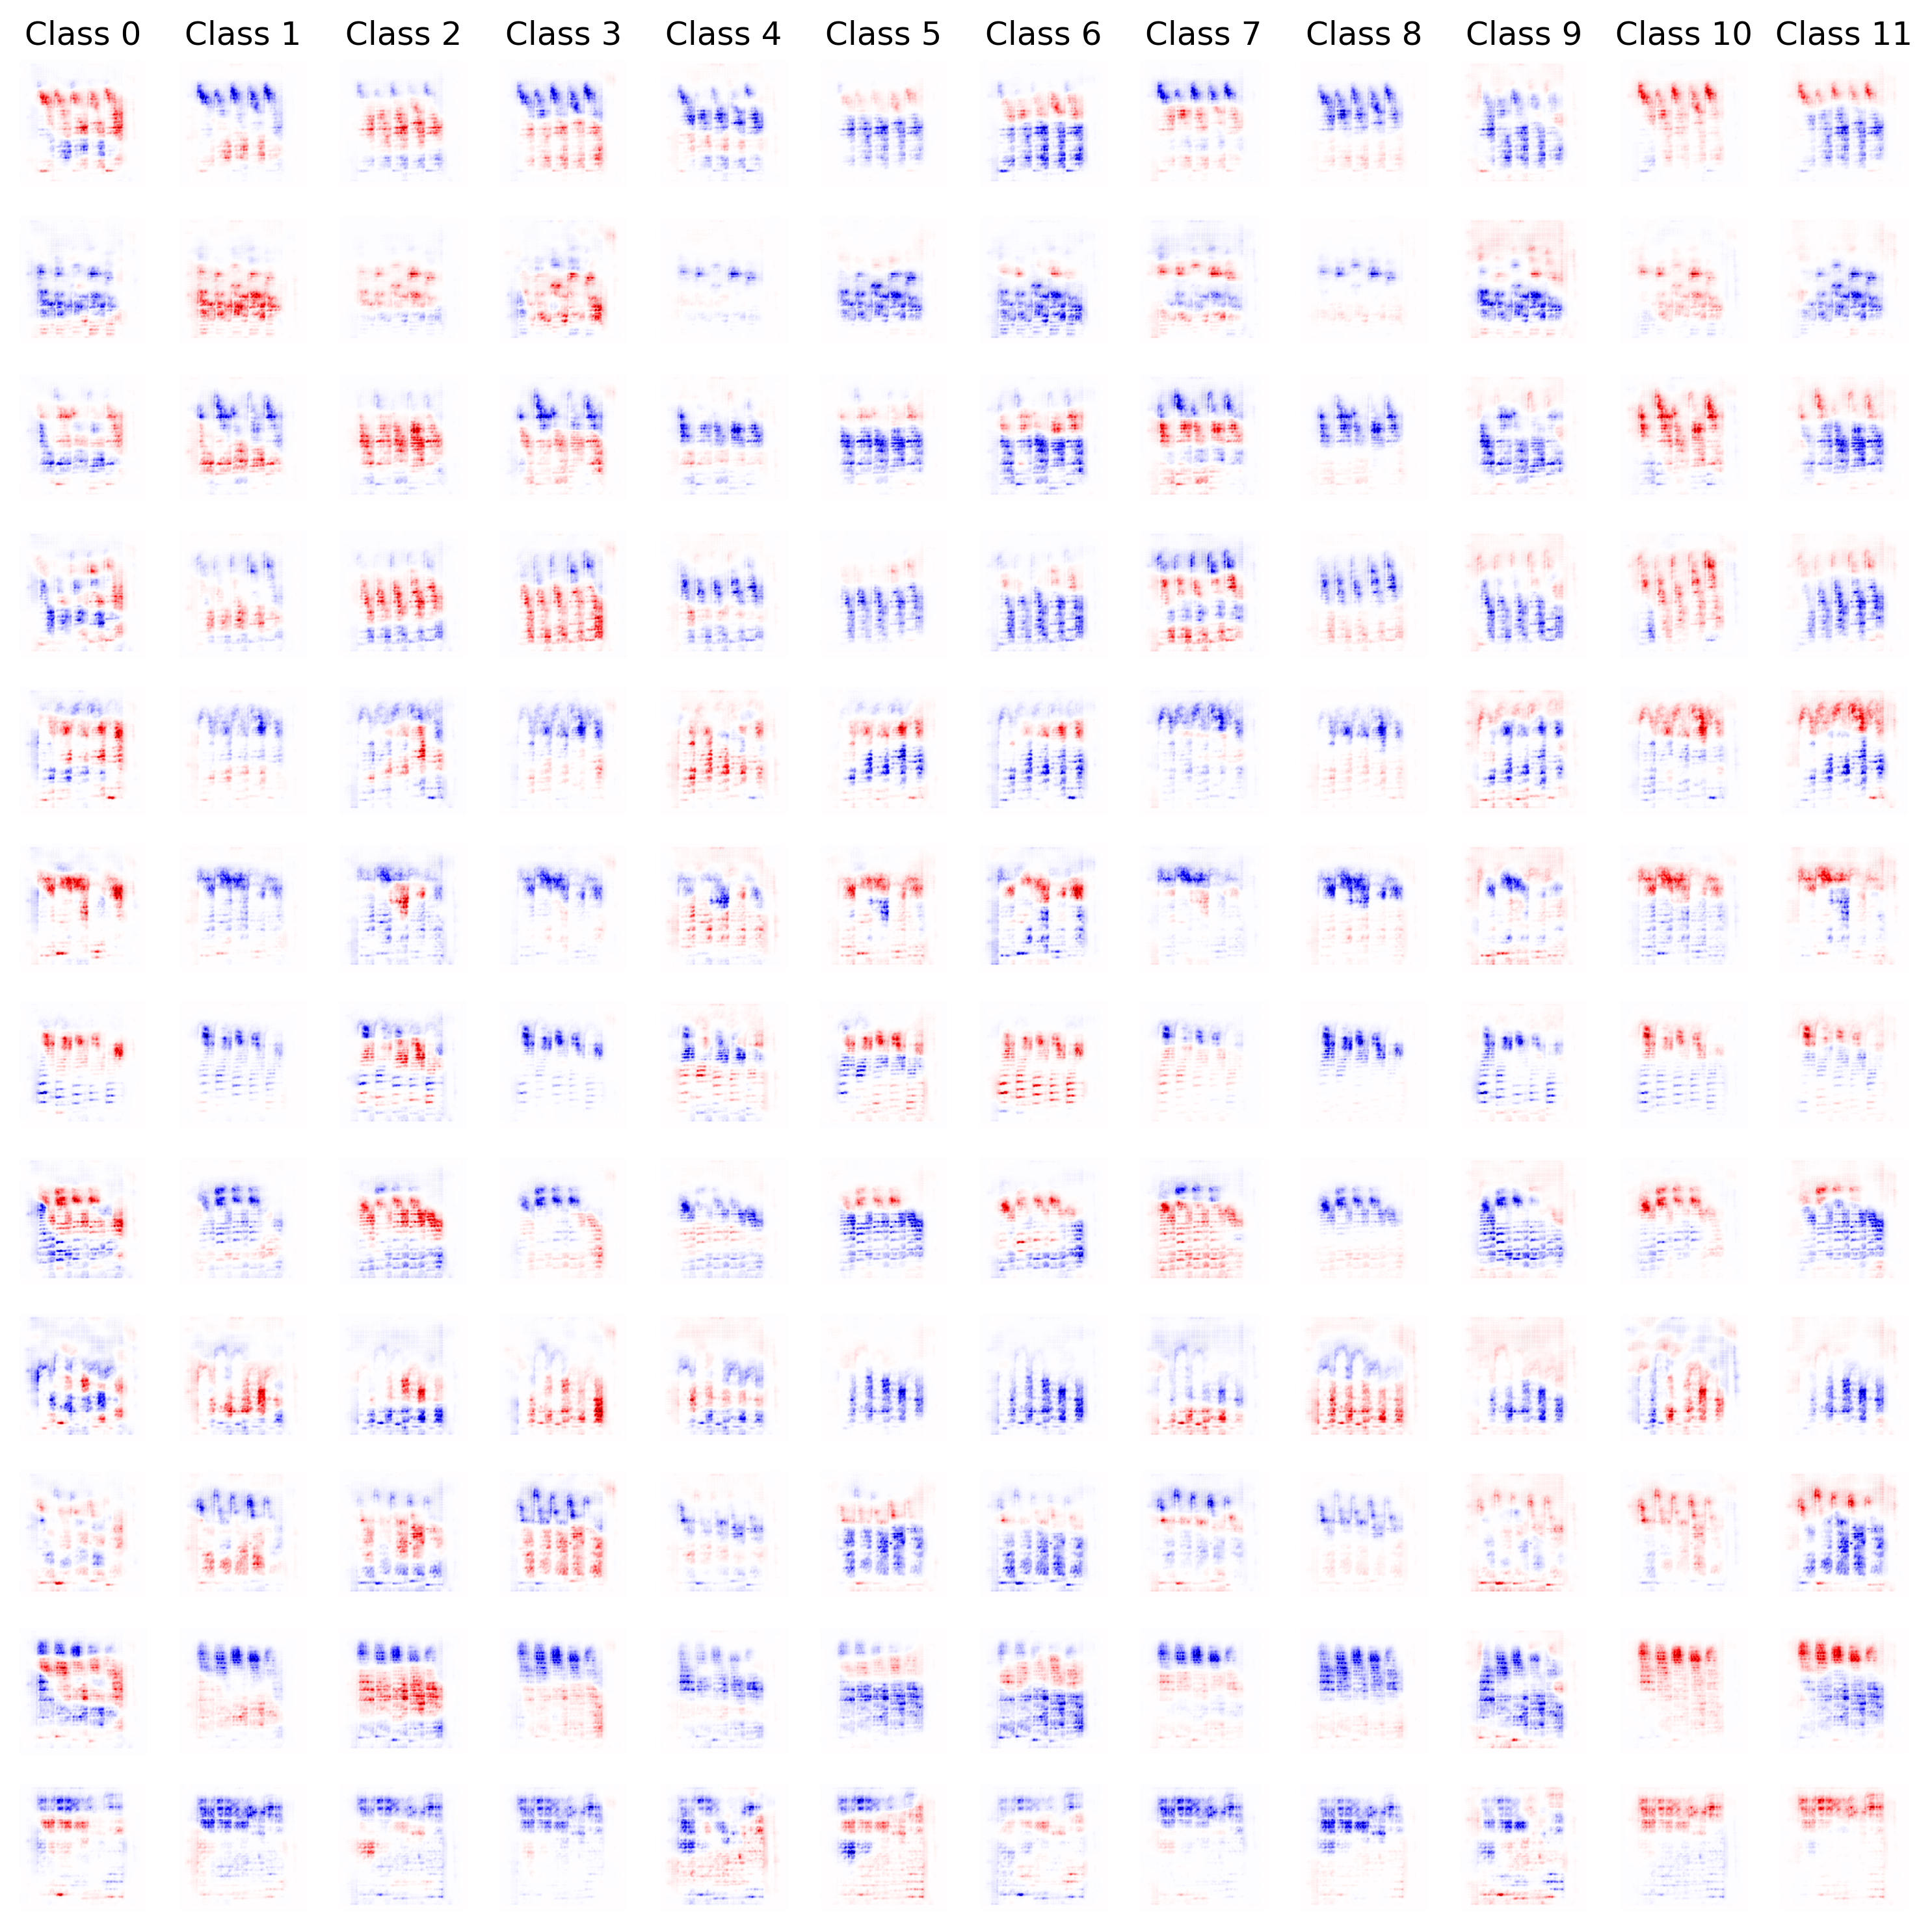

In [36]:
# cross compare all classes
fig, axes = plt.subplots(num_classes, num_classes, figsize=(10, 10), dpi=300)

cols = ['Class {}'.format(col) for col in range(num_classes)]
rows = ['is Class {}'.format(row) for row in range(num_classes)]

for i in range(num_classes):
    for j in range(num_classes):
        #print("i, j is:" + str(i) + ", " + str(j))
        sample = class_samples[i].unsqueeze(0).to(device)
        # compute heatmap
        conditions = [{"y": j}]

        # zennit requires gradients
        sample = sample.detach().requires_grad_(True)
        attr = attribution(sample, conditions, composite, mask_map=cc.mask)

        # or use a dictionary for mask_map
        layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
        mask_map = {name: cc.mask for name in layer_names}

        attr = attribution(sample, conditions, composite, mask_map=mask_map)

        max = torch.max(torch.abs(attr.heatmap))
        norm = Normalize(vmin=-max, vmax=max)
        axes[i, j].imshow(attr.heatmap.permute(1, 2, 0), cmap="seismic", norm=norm)
        axes[i, j].axis("off")

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=45)

plt.tight_layout()
plt.show()